# Boston 311 Tutorial

This notebook will run you through the basic usage of this package to train 4 models on the Boston 311 data and use them to predict the outcome of cases from the last 30 days

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-12-21 14:33:44.263467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 14:33:44.263504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 14:33:44.264847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 14:33:44.271348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 14:33:44.829708: W tensorflow/compiler/tf2

Num GPUs Available:  1


2023-12-21 14:33:45.715007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 14:33:45.831612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 14:33:45.831860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
#The lifelines library is only needed for the Cox Regression Model, which is not included in this tutorial
#The keras-tuner library is needed for the neural network model
#The seaborn library is needed for visualization of results at the end
! pip install -q lifelines keras-tuner seaborn

In [3]:
#! pip install git+https://github.com/mindfulcoder49/Boston_311.git

! pip install . 

Defaulting to user installation because normal site-packages is not writeable


Processing /home/briarmoss/Documents/Boston_311
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for boston311: filename=boston311-0.2.0-py3-none-any.whl size=24770 sha256=d314b09bff973b18123379d37391a25ab4392efd8d10dca31072eb3726fe0caf
  Stored in directory: /tmp/pip-ephem-wheel-cache-03hhxw71/wheels/3d/69/ee/0a6ac96b9c09c948fc0e74f2724a9703aa39749a41fa757c9e
Successfully built boston311
  Attempting uninstall: boston311
    Found existing installation: boston311 0.2.0
    Uninstalling boston311-0.2.0:
      Successfully uninstalled boston311-0.2.0


## Import the Boston311Model classes

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras_tuner import HyperParameters

/home/briarmoss/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using TensorFlow backend


In [5]:
from boston311 import Boston311LogReg, Boston311EventDecTree, Boston311SurvDecTree, Boston311KerasNN

## Get latest file URLS, Data, and Current Date Ranges

In [6]:
latest_URLS = Boston311LogReg().get311URLs()

trying to get csv URLs


Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmps809edg7.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv for year 2018
Found URL:

In [7]:
print(latest_URLS)

{'2023': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmps809edg7.csv', '2022': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv', '2021': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv', '2020': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv', '2019': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv', '2018': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv', '2017': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/300221

In [8]:
today_datestring, tomorrow_datestring, thirty_days_ago_datestring = Boston311LogReg().get_datestrings()

## Define several models

In [9]:
linear_tree_model = Boston311SurvDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type','queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0,
                                      'survivalTimeFill':tomorrow_datestring},
                            files_dict=latest_URLS)

hour_interval = 48
max_days = 120

linear_tree_model.bin_edges = linear_tree_model.generate_time_bins_fixed_interval(hour_interval, max_days)
linear_tree_model.bin_labels = linear_tree_model.generate_bin_labels(linear_tree_model.bin_edges)

In [10]:
logistic_model = Boston311LogReg(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

In [11]:
logistic_tree_model = Boston311EventDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

## Load the data once and store it for use on all the models

In [12]:
all_2023_data = Boston311LogReg(train_date_range={'start':'2023-01-01','end':'2023-12-31'}).load_data()

Checking files_dict
files_dict is None
trying to call get311URLs
trying to get csv URLs
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmps809edg7.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resourc

In [13]:
prediction_data_2023 = linear_tree_model.load_data(data=all_2023_data, train_or_predict='predict')    

In [14]:
case_data_2023 = linear_tree_model.load_data(data=all_2023_data)

## Train several models

In [15]:
logistic_tree_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-12-21 14:37:00.774781
Testing accuracy: 0.9538580922440208
Ending Training at 2023-12-21 14:37:14.142965
Training took 0:00:13.368184


0.9538580922440208

In [16]:
logistic_tree_prediction = logistic_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [17]:
logistic_tree_prediction['event_prediction'].value_counts()

event_prediction
1    17627
0     3509
Name: count, dtype: int64

In [18]:
logistic_tree_prediction[logistic_tree_prediction['event'] == 0].head(100)

,event_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
175,1,101005185732,2023-12-01 05:42:00,2023-12-15 05:42:37,NaT,OVERDUE,Open,,PRINTED : ACORN LIGHTS ARE OUT,Public Works Department,...,125 Summer St,2111.0,42.353100,-71.057440,0101000020E6100000A3ADBC1AADC351C0670C745D322D...,Constituent Call,NaT,0,3,NaN
179,1,101005185759,2023-12-01 05:59:00,2023-12-31 05:59:02,NaT,ONTIME,Open,,DSP12/1Heat - Excessive Insufficient,Inspectional Services,...,3193-3201 Washington St,2130.0,42.312834,-71.101479,0101000020E61000006B9C24A37EC651C0594516F20A28...,Constituent Call,NaT,0,11,NaN
238,0,101005185824,2023-12-01 06:31:12,NaN,NaT,ONTIME,Open,,Schedule Bulk Item Pickup,Public Works Department,...,8 Chisholm Rd,2131.0,42.275560,-71.127121,0101000020E61000009F9239BF22C851C081C0A9894523...,Self Service,NaT,0,18,NaN
241,0,101005186882,2023-12-02 04:18:55,NaN,NaT,ONTIME,Open,,Schedule Bulk Item Pickup,Public Works Department,...,19 Helena Rd,2122.0,42.286650,-71.055951,0101000020E61000005BF1D4B194C351C0097979EEB024...,Self Service,NaT,0,16,NaN
263,0,101005185869,2023-12-01 07:00:07,NaN,NaT,ONTIME,Open,,Schedule Bulk Item Pickup,Public Works Department,...,20 Badger Rd,2136.0,42.242110,-71.125111,0101000020E61000006B06EDD001C851C051B80F73FD1E...,Self Service,NaT,0,18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,1,101005192720,2023-12-07 03:21:00,2023-12-26 03:30:00,NaT,ONTIME,Open,,Abandoned Vehicles,Transportation - Traffic Division,...,103 Welles Ave,2124.0,42.289250,-71.065731,0101000020E6100000ABB731EE34C451C0E23DF8200625...,Citizens Connect App,NaT,0,16,NaN
21924,1,101005192758,2023-12-07 03:41:00,2023-12-08 03:41:13,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,70 Warren Ave,2116.0,42.344640,-71.072651,0101000020E61000001AD0524EA6C451C0B6B100261D2C...,Constituent Call,NaT,0,4,NaN
21944,1,101005192770,2023-12-07 03:46:00,2023-12-08 03:46:51,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,5 Saint James St,2119.0,42.326122,-71.083754,0101000020E610000016900A385CC551C0639DB05BBE29...,Constituent Call,NaT,0,12,NaN
21953,1,101005192810,2023-12-07 04:06:33,2023-12-08 04:06:36,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,26-28 Cordis St,2129.0,42.375750,-71.062800,0101000020E610000074990BEC04C451C09923778F1830...,Citizens Connect App,NaT,0,2,NaN


In [19]:
logistic_tree_model.save('.','logtree','logtreeproperties')

In [20]:
logistic_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-12-21 14:37:16.253520
Epoch 1/10


2023-12-21 14:37:16.441782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 14:37:16.442022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 14:37:16.442190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

  32/5026 [..............................] - ETA: 8s - loss: 0.6585 - accuracy: 0.6689   

2023-12-21 14:37:47.272345: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc00940ea30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 14:37:47.272370: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro M5000, Compute Capability 5.2
2023-12-21 14:37:47.276969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-21 14:37:47.293667: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1703187467.348152  406622 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5026/5026 [==============================] - 10s 2ms/step - loss: 0.2317 - accuracy: 0.9200 - val_loss: 0.1568 - val_accuracy: 0.9372
Epoch 2/10
5026/5026 [==============================] - 10s 2ms/step - loss: 0.1421 - accuracy: 0.9417 - val_loss: 0.1334 - val_accuracy: 0.9449
Epoch 3/10
5026/5026 [==============================] - 10s 2ms/step - loss: 0.1285 - accuracy: 0.9461 - val_loss: 0.1255 - val_accuracy: 0.9472
Epoch 4/10
5026/5026 [==============================] - 10s 2ms/step - loss: 0.1233 - accuracy: 0.9479 - val_loss: 0.1223 - val_accuracy: 0.9493
Epoch 5/10
5026/5026 [==============================] - 9s 2ms/step - loss: 0.1210 - accuracy: 0.9489 - val_loss: 0.1208 - val_accuracy: 0.9504
Epoch 6/10
5026/5026 [==============================] - 10s 2ms/step - loss: 0.1197 - accuracy: 0.9497 - val_loss: 0.1199 - val_accuracy: 0.9506
Epoch 7/10
5026/5026 [==============================] - 9s 2ms/step - loss: 0.1190 - accuracy: 0.9500 - val_loss: 0.1194 - val_accuracy: 0.950

0.9520872235298157

In [21]:
logistic_model.save('.','logreg','logregproperties')

In [22]:
logistic_prediction = logistic_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


478/661 [====================>.........] - ETA: 0s

661/661 [==============================] - 0s 533us/step


In [23]:
logistic_prediction[logistic_prediction['event_prediction'] < .5].shape[0]

909

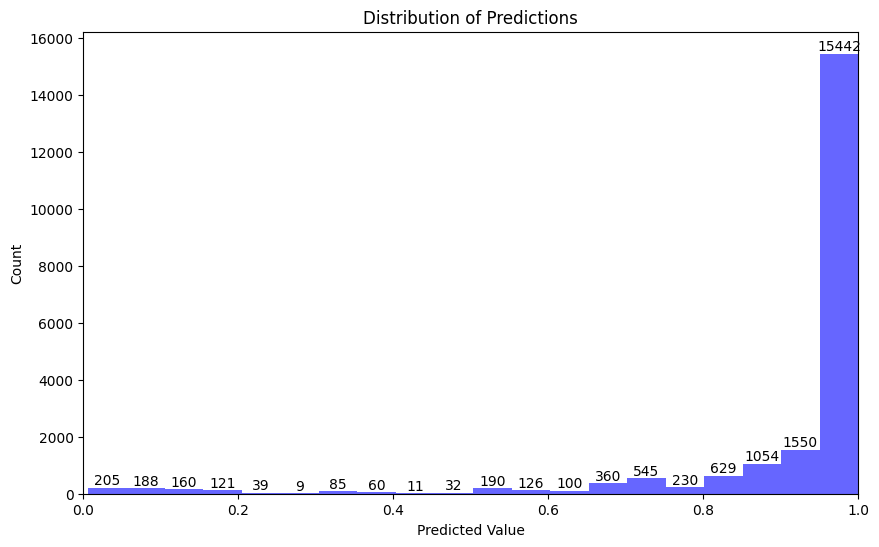

In [24]:
def plot_prediction_distribution(df, column):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the dataframe.")

    data = df[column]  # Extract the data from the dataframe

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data, bins=20, alpha=0.6, color='b')

    # Add counts above the bins
    for count, rect in zip(n, patches):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, f'{int(count)}', ha='center', va='bottom')

    plt.title('Distribution of Predictions')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.xlim(0, 1)  # Assuming the predictions are probabilities [0, 1]
    plt.show()

# Example usage:
plot_prediction_distribution(logistic_prediction, 'event_prediction')


In [25]:
linear_tree_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-12-21 14:39:27.736533
Testing accuracy: 0.6384854152572724
Ending Training at 2023-12-21 14:39:32.999450
Training took 0:00:05.262917


0.6384854152572724

In [26]:
linear_prediction = linear_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [27]:
linear_prediction.head(20)

,survival_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
134,0-2d,101005180856,2023-11-28 01:38:00,2023-11-29 03:30:00,2023-11-28 02:12:05,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:12:05...,Requests for Street Cleaning,Public Works Department,...,29 A St,2127.0,42.340928,-71.056283,0101000020E610000018EDA9259AC351C05E1EE18AA32B...,Constituent Call,0 days 00:34:05,1,6,0.568056
135,8w-8w2d,101005180860,2023-11-28 01:40:00,2023-11-30 03:30:00,2023-11-28 05:39:54,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 10:39:54...,Improper Storage of Trash (Barrels),Public Works Department,...,38 Allston St,2129.0,42.380810,-71.063370,0101000020E61000000994C1420EC451C05D93D35DBE30...,Constituent Call,0 days 03:59:54,1,2,3.998333
136,0-2d,101005180862,2023-11-28 01:41:59,2023-11-29 03:30:00,2023-11-28 03:23:32,ONTIME,Closed,Case Closed. Closed date : 2023-11-28 08:23:32...,Parking Enforcement,Transportation - Traffic Division,...,25 Northern Ave,2210.0,42.353231,-71.047537,0101000020E6100000FC534AD70AC351C019D5F4AA362D...,Citizens Connect App,0 days 01:41:33,1,6,1.692500
137,0-2d,101005180867,2023-11-28 01:43:29,NaN,2023-11-28 02:05:20,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:05:20...,Needle Pickup,Mayor's 24 Hour Hotline,...,INTERSECTION Worcester St & Newland St,NaN,42.338555,-71.076964,0101000020E6100000A25379FCECC451C0DF3B0FC3552B...,Citizens Connect App,0 days 00:21:51,1,9,0.364167
138,0-2d,101005180878,2023-11-28 01:55:39,NaN,2023-11-28 02:10:58,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:10:58...,Needle Pickup,Mayor's 24 Hour Hotline,...,515 Massachusetts Ave,2118.0,42.338880,-71.080261,0101000020E6100000D2491AFD22C551C02288B567602B...,Citizens Connect App,0 days 00:15:19,1,9,0.255278
139,10w2d-10w4d,101005180871,2023-11-28 01:47:00,2023-11-29 03:30:00,2023-12-08 06:31:11,OVERDUE,Closed,Case Closed. Closed date : 2023-12-08 11:31:11...,Sidewalk Repair (Make Safe),Public Works Department,...,INTERSECTION William Cardinal O'Connell Way & ...,NaN,42.363413,-71.066900,0101000020E6100000F0B8081948C451C0E14A604F842E...,Citizens Connect App,10 days 04:44:11,1,3,244.736389
141,0-2d,101005180897,2023-11-28 02:15:57,2023-11-29 03:30:00,2023-11-28 06:22:28,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 11:22:28...,Pick up Dead Animal,Public Works Department,...,104 Glendower Rd,2131.0,42.276360,-71.132921,0101000020E61000001C903CC681C851C0ACE89DC05F23...,Citizens Connect App,0 days 04:06:31,1,18,4.108611
143,0-2d,101005180946,2023-11-28 02:44:00,2023-11-29 03:30:00,2023-11-29 03:29:59,ONTIME,Closed,Case Closed. Closed date : 2023-11-29 08:29:59...,Parking Enforcement,Transportation - Traffic Division,...,21 Upton St,2118.0,42.342320,-71.071901,0101000020E6100000E8B99B049AC451C0B3706D20D12B...,Constituent Call,1 days 00:45:59,1,3,24.766389
144,0-2d,101005180962,2023-11-28 02:53:09,2023-11-29 03:30:00,2023-11-28 08:45:40,ONTIME,Closed,Case Closed. Closed date : 2023-11-28 13:45:40...,Parking Enforcement,Transportation - Traffic Division,...,9 Snow Hill St,2113.0,42.366014,-71.056456,0101000020E610000044C420F89CC351C0267A9589D92E...,Citizens Connect App,0 days 05:52:31,1,3,5.875278
145,0-2d,101005180964,2023-11-28 02:53:40,2023-11-29 03:30:00,2023-11-28 21:22:23,ONTIME,Closed,Case Closed. Closed date : 2023-11-29 02:22:23...,Parking Enforcement,Transportation - Traffic Division,...,65 Putnam St,2128.0,42.380419,-71.033630,0101000020E6100000EF0DE1FF26C251C0792BF495B130...,Citizens Connect App,0 days 18:28:43,1,1,18.478611


In [28]:
linear_prediction.shape[0]

21136

In [29]:
logistic_prediction.shape[0]

21136

In [30]:
logistic_tree_prediction.shape[0]

21136

##Join the tables

In [31]:
merged_df = logistic_tree_prediction.merge(logistic_prediction[['case_enquiry_id','event_prediction']], on='case_enquiry_id', how="outer").merge(linear_prediction[['case_enquiry_id','survival_prediction']], on='case_enquiry_id', how="outer")

In [32]:
merged_df.shape[0]

21136

In [33]:
merged_df.head()

,event_prediction_x,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours,event_prediction_y,survival_prediction
0,1,101005180856,2023-11-28 01:38:00,2023-11-29 03:30:00,2023-11-28 02:12:05,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:12:05...,Requests for Street Cleaning,Public Works Department,...,42.340928,-71.056283,0101000020E610000018EDA9259AC351C05E1EE18AA32B...,Constituent Call,0 days 00:34:05,1,6,0.568056,0.999998,0-2d
1,1,101005180860,2023-11-28 01:40:00,2023-11-30 03:30:00,2023-11-28 05:39:54,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 10:39:54...,Improper Storage of Trash (Barrels),Public Works Department,...,42.380810,-71.063370,0101000020E61000000994C1420EC451C05D93D35DBE30...,Constituent Call,0 days 03:59:54,1,2,3.998333,1.000000,8w-8w2d
2,1,101005180862,2023-11-28 01:41:59,2023-11-29 03:30:00,2023-11-28 03:23:32,ONTIME,Closed,Case Closed. Closed date : 2023-11-28 08:23:32...,Parking Enforcement,Transportation - Traffic Division,...,42.353231,-71.047537,0101000020E6100000FC534AD70AC351C019D5F4AA362D...,Citizens Connect App,0 days 01:41:33,1,6,1.692500,0.999877,0-2d
3,1,101005180867,2023-11-28 01:43:29,NaN,2023-11-28 02:05:20,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:05:20...,Needle Pickup,Mayor's 24 Hour Hotline,...,42.338555,-71.076964,0101000020E6100000A25379FCECC451C0DF3B0FC3552B...,Citizens Connect App,0 days 00:21:51,1,9,0.364167,1.000000,0-2d
4,1,101005180878,2023-11-28 01:55:39,NaN,2023-11-28 02:10:58,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:10:58...,Needle Pickup,Mayor's 24 Hour Hotline,...,42.338880,-71.080261,0101000020E6100000D2491AFD22C551C02288B567602B...,Citizens Connect App,0 days 00:15:19,1,9,0.255278,1.000000,0-2d


##Save the prediction data

In [34]:
merged_df.to_csv('predictions.csv', index=False)

In [35]:
import gc
gc.collect()

27

# Enter the Neural Network #

In [36]:
KerasNN_model = Boston311KerasNN()

In [37]:
KerasNN_model.train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring}

KerasNN_model.predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring}

KerasNN_model.feature_columns=['queue', 'type']

KerasNN_model.scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']}, 'survivalTimeMin':0, 'survivalTimeFill':tomorrow_datestring}

KerasNN_model.epochs = 2
KerasNN_model.batch_size = 32

In [38]:

hour_interval = 48
max_days = 120

#KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_statistics(df, num_intervals=60)
KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_fixed_interval(hour_interval, max_days)

start_nodes = 256
end_nodes = 128
#l2_0 = 0.00001
#learning_rate = 7.5842e-05
l2_0 = 0.001
learning_rate = 0.0001

hp = HyperParameters()
hp.Fixed('start_nodes', start_nodes)
hp.Fixed('end_nodes', end_nodes)
hp.Fixed('l2_0', l2_0)
hp.Fixed('learning_rate', learning_rate)
bin_number = len(KerasNN_model.bin_edges) - 1
hp.Fixed('final_layer', bin_number)
hp.Fixed('final_activation', 'softmax')
KerasNN_model.best_hyperparameters = hp

In [39]:
KerasNN_model.run_pipeline(data=case_data_2023)

bin_labels is None


Starting Training at 2023-12-21 14:39:36.861871
input_dim: 336
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               86272     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 61)                7869      
                                                                 
Total params: 127037 (496.24 KB)
Trainable params: 127037 (496.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
<class 'pandas.core.frame.DataFrame'> (201032, 61)
<class 'pandas.core.frame.DataFrame'> (50258, 61)
run fit



2023-12-21 14:39:38.669115: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 540374016 exceeds 10% of free system memory.
2023-12-21 14:39:39.125637: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 540374016 exceeds 10% of free system memory.


Epoch 1/2
6262/6283 [============================>.] - ETA: 0s - loss: 1.7290 - accuracy: 0.5935 - top_k_categorical_accuracy: 0.7041

2023-12-21 14:39:53.943495: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270187008 exceeds 10% of free system memory.


6283/6283 [==============================] - 19s 3ms/step - loss: 1.7282 - accuracy: 0.5935 - top_k_categorical_accuracy: 0.7042 - val_loss: 1.7395 - val_accuracy: 0.5730 - val_top_k_categorical_accuracy: 0.6638
Epoch 2/2
1571/1571 [==============================] - 2s 1ms/step - loss: 1.4797 - accuracy: 0.6093 - top_k_categorical_accuracy: 0.7205
Testing accuracy: 0.6093358397483826 
Top-2 accuracy: 0.7205420136451721 
Test loss: 1.4796969890594482
Ending Training at 2023-12-21 14:40:17.718945
Training took 0:00:40.857074


0.6093358397483826

In [40]:
predictions, data = KerasNN_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


661/661 [==============================] - 0s 627us/step


In [41]:
def get_top_predictions(bin_labels, predictions):
    # Check if the number of columns in predictions matches the length of bin_labels
    if len(bin_labels) != predictions.shape[1]:
        raise ValueError("The length of bin_labels must be equal to the number of columns in predictions")

    # Get the indices of the top 3 predictions for each row
    top_3_indices = np.argsort(-predictions, axis=1)[:, :3]

    # Map the indices to labels
    top_3_labels = np.array(bin_labels)[top_3_indices]

    return top_3_labels

def add_prediction_columns(cases_df, top_predictions):
    # Check if the number of rows in the DataFrame matches the number of predictions
    if cases_df.shape[0] != top_predictions.shape[0]:
        raise ValueError("The number of rows in cases_df must be equal to the number of predictions")

    # Create new columns for the predictions
    #cases_df['1st_prediction'] = top_predictions[:, 0]
    #cases_df['2nd_prediction'] = top_predictions[:, 1]
    #cases_df['3rd_prediction'] = top_predictions[:, 2]
    #use insert instead to put them on the left side
    cases_df.insert(0, '1st_prediction', top_predictions[:, 0])
    cases_df.insert(1, '2nd_prediction', top_predictions[:, 1])
    cases_df.insert(2, '3rd_prediction', top_predictions[:, 2])
    
    return cases_df

prediction_labels = get_top_predictions(KerasNN_model.bin_labels, predictions)
df_predictions = add_prediction_columns(data, prediction_labels)

In [42]:
df_predictions.shape[0]

21136

In [43]:
df_predictions.head(100)

,1st_prediction,2nd_prediction,3rd_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
134,0-2d,2d-4d,4d-6d,101005180856,2023-11-28 01:38:00,2023-11-29 03:30:00,2023-11-28 02:12:05,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:12:05...,...,29 A St,2127.0,42.340928,-71.056283,0101000020E610000018EDA9259AC351C05E1EE18AA32B...,Constituent Call,0 days 00:34:05,1,6,0.568056
135,0-2d,2d-4d,4d-6d,101005180860,2023-11-28 01:40:00,2023-11-30 03:30:00,2023-11-28 05:39:54,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 10:39:54...,...,38 Allston St,2129.0,42.380810,-71.063370,0101000020E61000000994C1420EC451C05D93D35DBE30...,Constituent Call,0 days 03:59:54,1,2,3.998333
136,0-2d,2d-4d,4d-6d,101005180862,2023-11-28 01:41:59,2023-11-29 03:30:00,2023-11-28 03:23:32,ONTIME,Closed,Case Closed. Closed date : 2023-11-28 08:23:32...,...,25 Northern Ave,2210.0,42.353231,-71.047537,0101000020E6100000FC534AD70AC351C019D5F4AA362D...,Citizens Connect App,0 days 01:41:33,1,6,1.692500
137,0-2d,2d-4d,4d-6d,101005180867,2023-11-28 01:43:29,NaN,2023-11-28 02:05:20,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:05:20...,...,INTERSECTION Worcester St & Newland St,NaN,42.338555,-71.076964,0101000020E6100000A25379FCECC451C0DF3B0FC3552B...,Citizens Connect App,0 days 00:21:51,1,9,0.364167
138,0-2d,2d-4d,4d-6d,101005180878,2023-11-28 01:55:39,NaN,2023-11-28 02:10:58,ONTIME,Closed,Case Closed. Closed date : Tue Nov 28 07:10:58...,...,515 Massachusetts Ave,2118.0,42.338880,-71.080261,0101000020E6100000D2491AFD22C551C02288B567602B...,Citizens Connect App,0 days 00:15:19,1,9,0.255278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0-2d,2d-4d,4d-6d,101005187605,2023-12-02 14:59:57,2023-12-05 03:30:00,2023-12-04 02:47:36,ONTIME,Closed,Case Closed. Closed date : Mon Dec 04 07:47:36...,...,31 Burbank St,2115.0,42.344495,-71.087748,0101000020E6100000B15E24AA9DC551C0C879FD68182C...,Citizens Connect App,1 days 11:47:39,1,4,35.794167
397,0-2d,2d-4d,4d-6d,101005187815,2023-12-03 04:21:00,2023-12-06 03:30:00,2023-12-03 05:56:40,ONTIME,Closed,Case Closed. Closed date : Sun Dec 03 10:56:40...,...,INTERSECTION Tuckerman St & Middle St,NaN,42.331395,-71.055025,0101000020E6100000AB068F8785C351C03A0C132A6B2A...,Citizens Connect App,0 days 01:35:40,1,7,1.594444
398,0-2d,2d-4d,4d-6d,101005187821,2023-12-03 04:27:04,2023-12-05 03:30:00,2023-12-03 20:57:30,ONTIME,Closed,Case Closed. Closed date : 2023-12-04 01:57:30...,...,773 Tremont St,2118.0,42.339680,-71.080111,0101000020E6100000AB08F38720C551C058DA979E7A2B...,Citizens Connect App,0 days 16:30:26,1,9,16.507222
403,0-2d,2d-4d,4d-6d,101005187827,2023-12-03 04:34:41,2023-12-05 03:30:00,2023-12-03 20:56:50,ONTIME,Closed,Case Closed. Closed date : 2023-12-04 01:56:50...,...,15 Hopedale St,2134.0,42.359550,-71.126691,0101000020E6100000E552E1B21BC851C04E09BAB8052E...,Citizens Connect App,0 days 16:22:09,1,22,16.369167


In [44]:
#add the three prediction columns to the merged_df by merging on case_enquiry_id
merged_df = merged_df.merge(df_predictions[['case_enquiry_id','1st_prediction','2nd_prediction','3rd_prediction']], on='case_enquiry_id', how="outer")

In [45]:
# Select and view the first 20 records of the specified columns
columns_to_view = ['1st_prediction', '2nd_prediction', '3rd_prediction', 'survival_prediction', 'event_prediction_x', 'event_prediction_y', 'case_enquiry_id','open_dt','closed_dt','survival_time','case_title','type','queue']
merged_df[columns_to_view].head(20)


,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
0,0-2d,2d-4d,4d-6d,0-2d,1,0.999998,101005180856,2023-11-28 01:38:00,2023-11-28 02:12:05,0 days 00:34:05,Requests for Street Cleaning,Requests for Street Cleaning,PWDx_District 05: South Boston
1,0-2d,2d-4d,4d-6d,8w-8w2d,1,1.000000,101005180860,2023-11-28 01:40:00,2023-11-28 05:39:54,0 days 03:59:54,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
2,0-2d,2d-4d,4d-6d,0-2d,1,0.999877,101005180862,2023-11-28 01:41:59,2023-11-28 03:23:32,0 days 01:41:33,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
3,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005180867,2023-11-28 01:43:29,2023-11-28 02:05:20,0 days 00:21:51,Needle Pickup,Needle Pickup,GEN_Needle_Pickup
4,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005180878,2023-11-28 01:55:39,2023-11-28 02:10:58,0 days 00:15:19,Needle Pickup,Needle Pickup,GEN_Needle_Pickup
5,over 114y24w2d16h,0-2d,2d-4d,10w2d-10w4d,1,0.503281,101005180871,2023-11-28 01:47:00,2023-12-08 06:31:11,10 days 04:44:11,Sidewalk Repair (Make Safe),Sidewalk Repair (Make Safe),PWDx_Sidewalk Repair
6,0-2d,2d-4d,4d-6d,0-2d,1,0.999997,101005180897,2023-11-28 02:15:57,2023-11-28 06:22:28,0 days 04:06:31,Pick up Dead Animal,Pick up Dead Animal,PWDx_District 06: West Roxbury and Roslindale
7,0-2d,2d-4d,4d-6d,0-2d,1,0.999877,101005180946,2023-11-28 02:44:00,2023-11-29 03:29:59,1 days 00:45:59,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
8,0-2d,2d-4d,4d-6d,0-2d,1,0.999877,101005180962,2023-11-28 02:53:09,2023-11-28 08:45:40,0 days 05:52:31,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
9,0-2d,2d-4d,4d-6d,0-2d,1,0.999877,101005180964,2023-11-28 02:53:40,2023-11-28 21:22:23,0 days 18:28:43,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement


In [46]:
#now show the first 20 that have event=0
merged_df[merged_df['event'] == 0][columns_to_view].head(20)

,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
17,0-2d,over 114y24w2d16h,2d-4d,0-2d,1,0.843409,101005185732,2023-12-01 05:42:00,NaT,NaT,PRINTED : ACORN LIGHTS ARE OUT,Street Light Outages,PWDx_Street Light Outages
21,0-2d,over 114y24w2d16h,2d-4d,0-2d,1,0.827821,101005185759,2023-12-01 05:59:00,NaT,NaT,DSP12/1Heat - Excessive Insufficient,Heat - Excessive Insufficient,ISD_Housing (INTERNAL)
32,2d-4d,4d-6d,6d-1w1d,4w4d-4w6d,0,0.899899,101005185824,2023-12-01 06:31:12,NaT,NaT,Schedule Bulk Item Pickup,Schedule a Bulk Item Pickup SS,PWDx_Schedule a Bulk Item Pickup
35,2d-4d,4d-6d,6d-1w1d,4w4d-4w6d,0,0.899899,101005186882,2023-12-02 04:18:55,NaT,NaT,Schedule Bulk Item Pickup,Schedule a Bulk Item Pickup SS,PWDx_Schedule a Bulk Item Pickup
41,2d-4d,4d-6d,6d-1w1d,4w4d-4w6d,0,0.899899,101005185869,2023-12-01 07:00:07,NaT,NaT,Schedule Bulk Item Pickup,Schedule a Bulk Item Pickup SS,PWDx_Schedule a Bulk Item Pickup
43,0-2d,2d-4d,4d-6d,0-2d,1,0.999877,101005185899,2023-12-01 07:12:00,NaT,NaT,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
45,2d-4d,4d-6d,6d-1w1d,4w6d-5w1d,0,0.920210,101005185910,2023-12-01 07:17:00,NaT,NaT,Schedule a Bulk Item Pickup,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup
46,2d-4d,4d-6d,6d-1w1d,4w6d-5w1d,0,0.920210,101005185906,2023-12-01 07:15:00,NaT,NaT,Schedule a Bulk Item Pickup,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup
48,over 114y24w2d16h,0-2d,2d-4d,4w6d-5w1d,0,0.008275,101005185946,2023-12-01 07:36:00,NaT,NaT,BTDT: Complaint,General Comments For An Employee,BTDT_General Comments
49,2d-4d,4d-6d,6d-1w1d,4w6d-5w1d,0,0.920210,101005185959,2023-12-01 07:45:00,NaT,NaT,Schedule a Bulk Item Pickup,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup


In [47]:


def plot_prediction_distribution(df, prediction_cols):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create figure and axes
    fig, axes = plt.subplots(nrows=len(prediction_cols), figsize=(10, 5 * len(prediction_cols)))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # Plot the distribution of each prediction
    for ax, col in zip(axes, prediction_cols):
        sns.countplot(data=df, x=col, hue=col, palette="viridis", order=df[col].value_counts().index, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Frequency')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

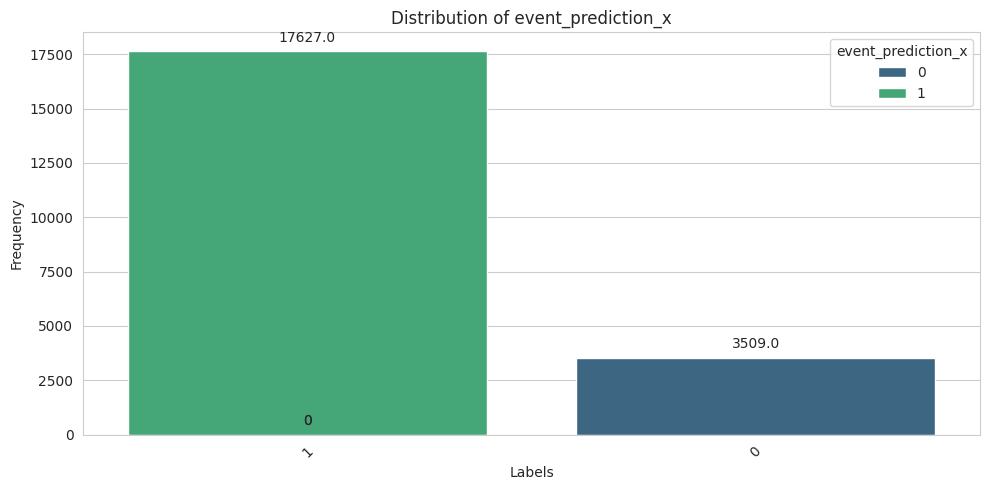

In [48]:
# Assuming `merged_df` is your DataFrame with columns '1st_prediction', '2nd_prediction', '3rd_prediction'
# Example usage:
plot_prediction_distribution(merged_df, ['event_prediction_x'])

In [49]:
merged_df['survival_prediction'].value_counts()

survival_prediction
0-2d                  11267
10w2d-10w4d            2003
2w-2w2d                1951
4w6d-5w1d              1469
4w4d-4w6d              1086
9w1d-9w3d               586
8w-8w2d                 567
14w2d-14w4d             426
1w1d-1w3d               386
4d-6d                   371
16w4d-16w6d             198
4w2d-4w4d               162
12w2d-12w4d             146
2d-4d                   131
3w3d-3w5d               105
2w4d-2w6d                92
2w2d-2w4d                78
1w3d-1w5d                41
6d-1w1d                  34
1w5d-2w                   9
6w6d-7w1d                 6
6w4d-6w6d                 3
7w5d-8w                   3
5w5d-6w                   3
5w1d-5w3d                 3
15w1d-15w3d               2
5w3d-5w5d                 2
12w4d-12w6d               2
6w-6w2d                   1
8w2d-8w4d                 1
17w1d-114y24w2d16h        1
8w4d-8w6d                 1
Name: count, dtype: int64

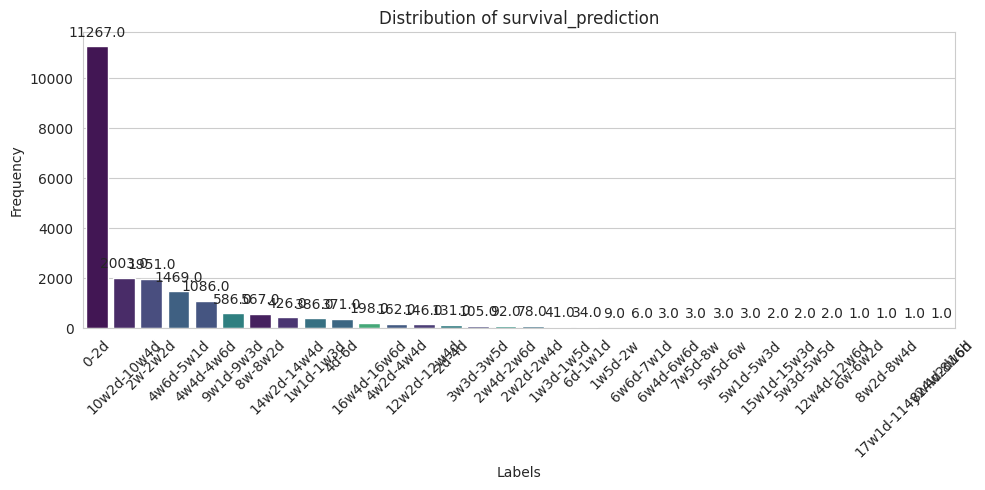

In [50]:

plot_prediction_distribution(merged_df, ['survival_prediction'])

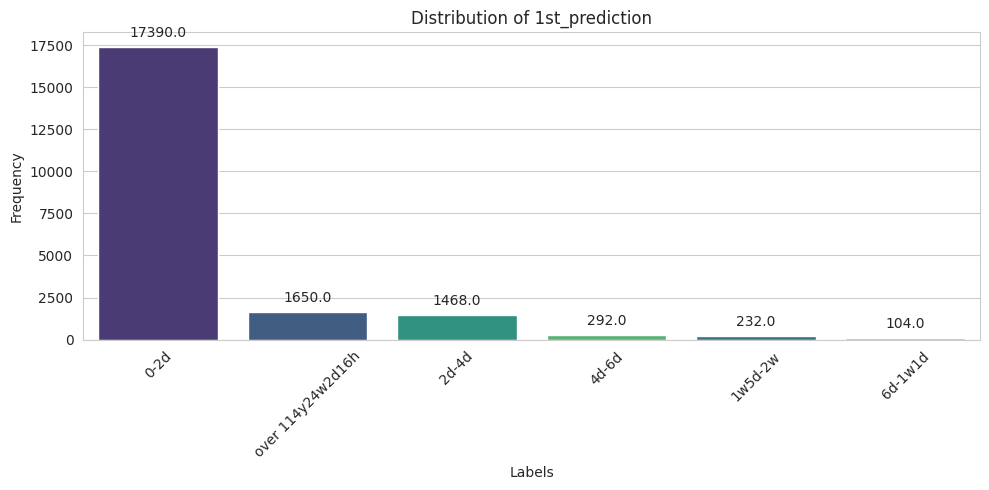

In [51]:

plot_prediction_distribution(merged_df, ['1st_prediction'])

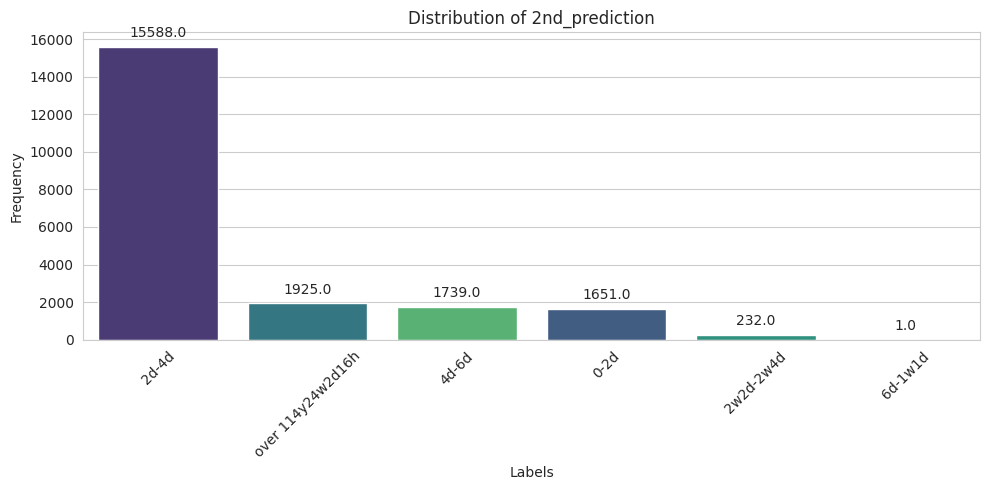

In [52]:

plot_prediction_distribution(merged_df, ['2nd_prediction'])

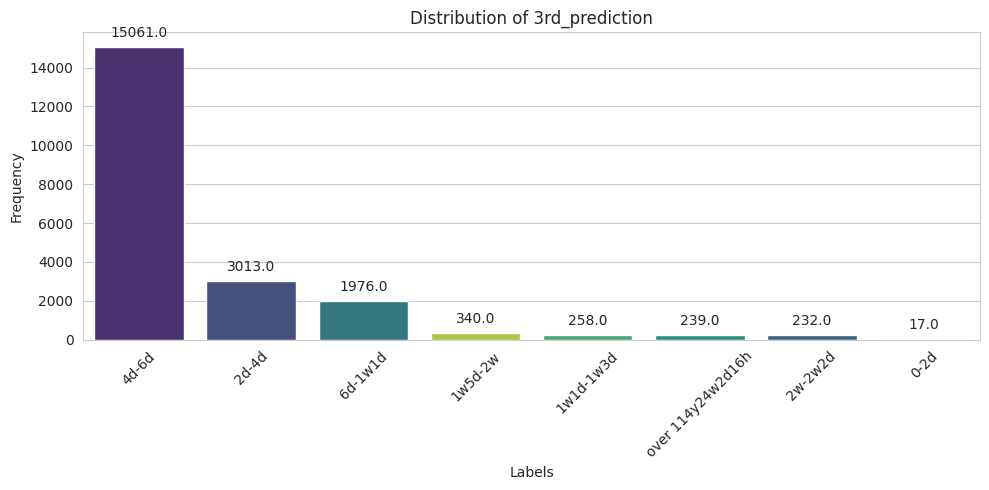

In [53]:

plot_prediction_distribution(merged_df, ['3rd_prediction'])